In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#save start date and end date for trip 
start_date = dt.date(2016, 10, 15)
end_date = dt.date(2016, 10, 30)

# Exploratory Climate Analysis

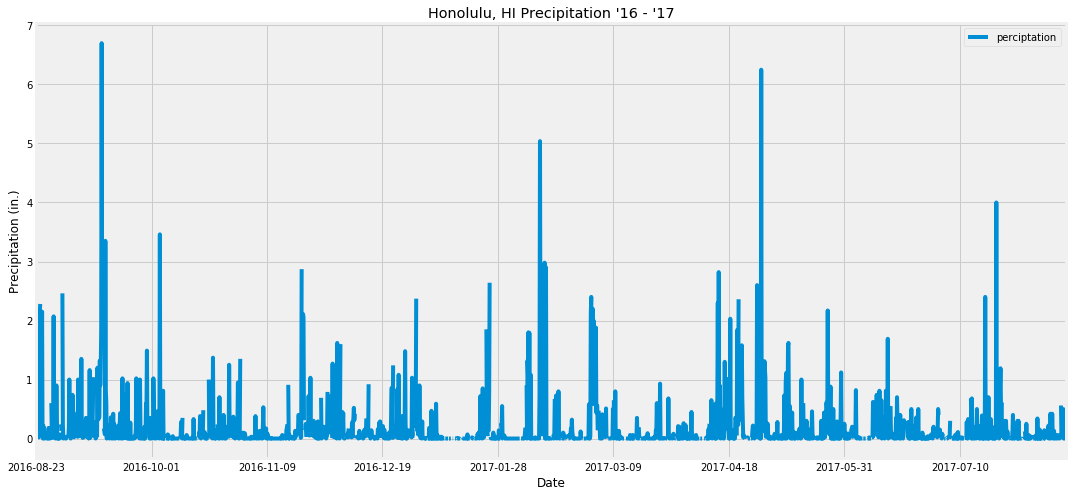

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# sample_dates = session.query(Measurement.date,Measurement.date).limit(5).all()
# for result in sample_dates:
#     print(result)

# Calculate the date 1 year ago from the last data point in the database

# last date in the database is 2017-08-23 from looking at tail so we will get dates between 2017-08-23 and 2016-08-23       


# Perform a query to retrieve the data and precipitation scores
precep_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()
precep_df = pd.DataFrame(precep_data, columns = ['date', 'perciptation'])
precep_df.tail()


# Save the query results as a Pandas DataFrame and set the index to the date column

precep_df.set_index('date', inplace = True)

# Sort the dataframe by date
precep_df = precep_df.sort_values(by = 'date')
precep_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (15, 7))
precep_df.plot(ax = ax, x_compat = True)

#set title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Honolulu, HI Precipitation '16 - '17")

#save figure
plt.savefig("precep.png")

#plot figure
plt.tight_layout()
plt.show()


![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precep_df.describe()

,perciptation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
num_of_stations = session.query(Station.id).distinct().count()
num_of_stations

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()
           

for result in station_counts:
    print(f"Station: {result[0]}\tCount: {result[1]}")
             



Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station?
station_id = 'USC00519281'
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_id).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")


Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


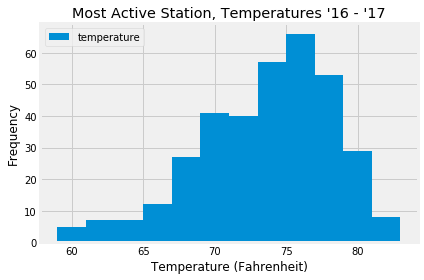

In [19]:
# Choose the station with the highest number of temperature observations.
most_active_station = 'USC00519281'
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
yearly_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

#save as a data frame
yearly_temps_df = pd.DataFrame(yearly_temps, columns = ['date', 'temperature'])
yearly_temps_df.head()

yearly_temps_df.set_index('date', inplace = True)

#yearly_temps_df = yearly_temps_df.sort_values(by = 'date')

#plot using matplotlib

fig, ax = plt.subplots()
yearly_temps_df.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Most Active Station, Temperatures '16 - '17")

#save figure
plt.savefig("temp.png")

#plot
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2016-10-15', '2016-10-30')
print(trip_temp)

[(68.0, 76.79411764705883, 81.0)]


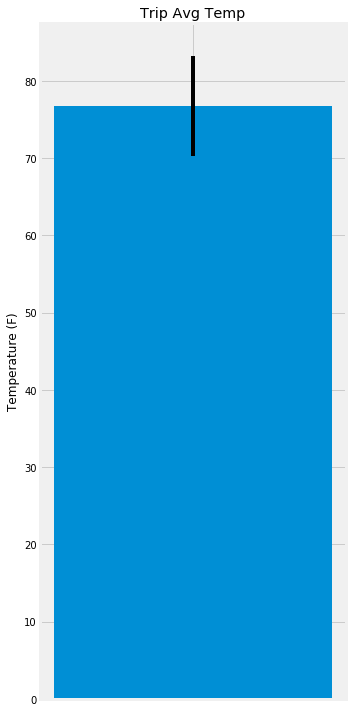

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmax_to_tmin = trip_temp[0][2] - trip_temp[0][0]
avg_temp = trip_temp[0][1]

#plot figure
fig, ax = plt.subplots(figsize = (5, 10))

ax.bar(1, avg_temp, yerr = tmax_to_tmin/2, width = 0.4)

#set labels
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temperature (F)')

#save fig
plt.savefig("temperror")

#show figure
plt.tight_layout()
plt.show()

In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_trip = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

rainfall_trip_df = pd.DataFrame(rainfall_trip, columns = ['Station','Name','Latitude','Longtitude','Elevation','Avg. Precipitation (in.)'])
rainfall_trip_df.head()


,Station,Name,Latitude,Longtitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051


## Optional Challenge Assignment

In [42]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [43]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_dates = ["10-15", "10-016", "10-17", "10-18", "10-19", "10-20", "10-21", "10-22", "10-23", "10-24", "10-25",
             "10-26", "10-27", "10-28", "10-29"]

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms = []

for trip_date in trip_dates:
    day = {}
    day['Date'] = f"2019-{trip_date}"
    daily_norm = daily_normals(trip_date)
    day['Min'] = daily_norm[0][0]
    day['Avg'] = daily_norm[0][1]
    day['Max'] = daily_norm[0][2]
    daily_norms.append(day)
    
daily_norms

[{'Date': '2019-10-15', 'Min': 67.0, 'Avg': 75.63461538461539, 'Max': 82.0},
 {'Date': '2019-10-016', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-10-17', 'Min': 65.0, 'Avg': 75.07843137254902, 'Max': 83.0},
 {'Date': '2019-10-18', 'Min': 65.0, 'Avg': 75.0, 'Max': 83.0},
 {'Date': '2019-10-19', 'Min': 65.0, 'Avg': 73.24489795918367, 'Max': 81.0},
 {'Date': '2019-10-20', 'Min': 67.0, 'Avg': 74.79629629629629, 'Max': 82.0},
 {'Date': '2019-10-21', 'Min': 66.0, 'Avg': 74.96078431372548, 'Max': 82.0},
 {'Date': '2019-10-22', 'Min': 66.0, 'Avg': 74.84313725490196, 'Max': 81.0},
 {'Date': '2019-10-23', 'Min': 66.0, 'Avg': 75.74468085106383, 'Max': 84.0},
 {'Date': '2019-10-24', 'Min': 69.0, 'Avg': 74.98039215686275, 'Max': 81.0},
 {'Date': '2019-10-25', 'Min': 68.0, 'Avg': 75.0, 'Max': 81.0},
 {'Date': '2019-10-26', 'Min': 68.0, 'Avg': 75.17307692307692, 'Max': 81.0},
 {'Date': '2019-10-27', 'Min': 64.0, 'Avg': 75.12, 'Max': 81.0},
 {'Date': '2019-10-28', 'Min': 68.0, 'Avg': 74.75

In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame(daily_norms)
#set index
daily_norms_df.set_index('Date', inplace = True)

#display
daily_norms_df

,Avg,Max,Min
Date,,,
2019-10-15,75.634615,82.0,67.0
2019-10-016,NaN,NaN,NaN
2019-10-17,75.078431,83.0,65.0
2019-10-18,75.000000,83.0,65.0
2019-10-19,73.244898,81.0,65.0
2019-10-20,74.796296,82.0,67.0
2019-10-21,74.960784,82.0,66.0
2019-10-22,74.843137,81.0,66.0
2019-10-23,75.744681,84.0,66.0


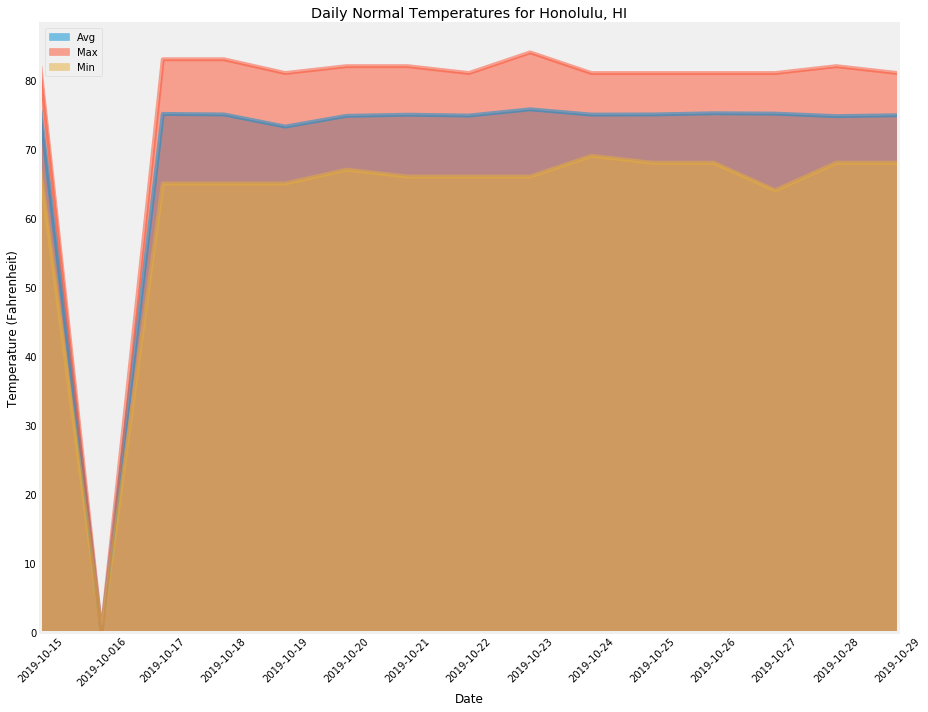

In [47]:
# Plot the daily normals as an area plot with `stacked=False`

fig, ax = plt.subplots(figsize = (13, 10))
daily_norms_df.plot.area(ax = ax, stacked = False)

#set labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu, HI')

#set ticks
dates = [f"2019-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)

#save figure
plt.savefig('dailynormal.png')

#show
plt.grid()
plt.tight_layout()
plt.show()